# LangGraph Policy Rollout

Use this notebook to run the LangGraph-based policy research loop locally **and** inspect the graph/tool composition before executing a rollout. You'll wire up the policy tools, draw the LangGraph (similar to the simpler arithmetic example), then step the compiled agent to generate an episode JSONL entry that the offline eval script can score.

In [1]:
import uuid
from pprint import pprint
import os
import sys
from pathlib import Path
from dotenv import load_dotenv

REPO_ROOT = (Path.cwd() / '..').resolve()
if str(REPO_ROOT) not in sys.path:
    sys.path.append(str(REPO_ROOT))

load_dotenv()
print(f'Repo root: {REPO_ROOT}')

from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage, messages_to_dict

from policy_src.policy_agent_lc.graph import build_graph
from policy_src.policy_agent_lc.graph import PHASE_TRANSITIONS
from policy_src.policy_agent_lc.io import append_jsonl
from policy_src.policy_agent_lc.prompts import load_system_prompt
from policy_src.policy_agent_lc.rollout import select_task
from policy_src.policy_agent_lc.session import ResearchSession
from policy_src.policy_agent_lc.tools import build_tools
from policy_src.policy_research_core.reward import compute_reward
from eval.offline_eval import load_tasks as eval_load_tasks, load_jsonl as eval_load_jsonl, print_report

os.environ['OPENAI_API_KEY'] = open('/Users/spangher/.openai-reglab-project-key.txt').read().strip()
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGSMITH_API_KEY'] = open('/Users/spangher/.langsmith-key.txt').read().strip()
os.environ['LANGSMITH_PROJECT'] = 'Policy LangGraph Rollout'

Repo root: /Users/spangher/Projects/stanford-research/rfi-research/regulations-demo/scripts/policy-deep-research-agent


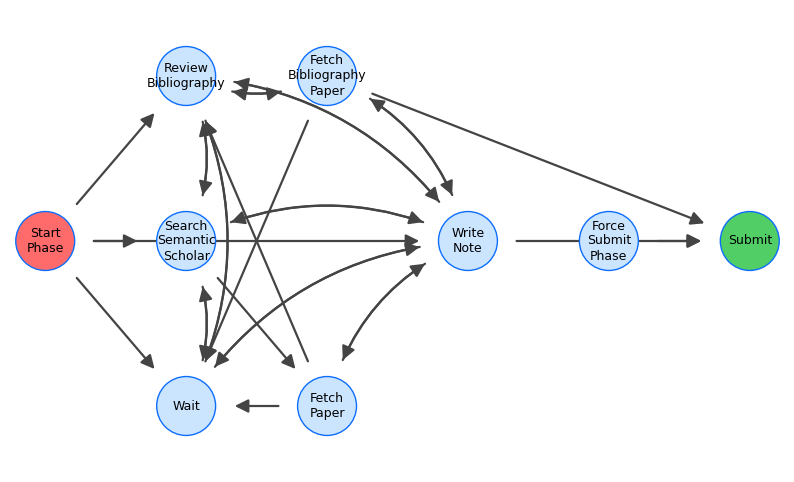

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

viz_graph = nx.DiGraph()
for src, targets in PHASE_TRANSITIONS.items():
    for tgt in targets:
        viz_graph.add_edge(src, tgt)

layer_order = [
    ["start_phase"],
    ["review_bibliography", "search_semantic_scholar", "wait"],
    ["fetch_bibliography_paper", "fetch_paper"],
    ["write_note"],
    ["force_submit_phase"],
    ["submit"],
]
pos = {}
for layer_idx, layer in enumerate(layer_order):
    count = len(layer) or 1
    for node_idx, node in enumerate(layer):
        x = layer_idx / (len(layer_order) - 1 if len(layer_order) > 1 else 1)
        y = 1 - node_idx / max(count - 1, 1) if count > 1 else 0.5
        pos[node] = (x, y)
for node in viz_graph.nodes:
    pos.setdefault(node, (0.5, 0.5))

color_map = []
for node in viz_graph.nodes:
    if node == "start_phase":
        color_map.append("#ff6b6b")
    elif node == "submit":
        color_map.append("#51cf66")
    else:
        color_map.append("#cce5ff")

plt.figure(figsize=(10, 6))
ax = plt.gca()
nx.draw_networkx_nodes(viz_graph, pos, node_color=color_map, node_size=1800, edgecolors="#0d6efd")
labels = {node: node.replace("_", "\n").title() for node in viz_graph.nodes}
nx.draw_networkx_labels(viz_graph, pos, labels=labels, font_size=9)
for u, v in viz_graph.edges():
    rad = 0.0
    if viz_graph.has_edge(v, u) and u != v:
        rad = 0.25 if u > v else -0.25
    arrow = FancyArrowPatch(
        pos[u],
        pos[v],
        connectionstyle=f"arc3,rad={rad}",
        arrowstyle="-|>",
        mutation_scale=20,
        linewidth=1.6,
        color="#444444",
        shrinkA=35,
        shrinkB=35,
        zorder=1,
    )
    ax.add_patch(arrow)
plt.ylim(-0.2, 1.2)
plt.xlim(-0.05, 1.05)
# plt.title("High-Level Tool/Phase Transitions (write_note enforced)")
plt.axis("off")
plt.show()


In [6]:
# --- Configuration ---
MODEL_NAME = 'gpt-5-mini'          # Any LangChain ChatOpenAI-compatible name (or vLLM endpoint)
TASK_INDEX = 0                      # Which policy question to run
USE_CACHED = True                   # True -> only use cached Semantic Scholar responses
MAX_STEPS = 12                      # RL budget; submit before hitting this limit
CACHE_PATH = 'data/cache/policy_cache.sqlite'
OUTPUT_PATH = Path('data/cache/rollouts_langgraph.jsonl')
TEMPERATURE = 1
TASKS_PATH = Path('data/tasks/policy_questions.jsonl')
SESSION_INSTRUCTIONS = (
    'Use the tools to search Semantic Scholar, fetch papers, build a bibliography with reasons, '
    'take notes, then submit a final memo.'
)
if MAX_STEPS:
    SESSION_INSTRUCTIONS += f' You may issue at most {MAX_STEPS} tool calls; reserve the final step for `submit`.'

# Optional: uncomment if you want to load an API key from disk.
# os.environ['OPENAI_API_KEY'] = Path('~/.openai-reglab-project-key.txt').expanduser().read_text().strip()

print(f'Model: {MODEL_NAME}')
print(f'Writing episodes to: {OUTPUT_PATH}')


Model: gpt-5-mini
Writing episodes to: data/cache/rollouts_langgraph.jsonl


In [7]:
task = select_task(TASK_INDEX)
print(f"Task {task['task_id']}: {task['question']}")

session = ResearchSession(
    task_id=task.get('task_id', str(TASK_INDEX)),
    question=task.get('question', ''),
    instructions=SESSION_INSTRUCTIONS,
    use_cached=USE_CACHED,
    max_steps=MAX_STEPS,
    cache_path=CACHE_PATH,
)

policy_root = REPO_ROOT / 'policy_src'
system_prompt = load_system_prompt(policy_root)
print('\nLoaded system prompt (first 400 chars):')
print(system_prompt[:400])

Task policy_001: How are US states leveraging carbon pricing mechanisms to fund climate resilience?

Loaded system prompt (first 400 chars):
You are an expert policy analyst who is responding to a request-for-information issued by the government. 
For each task, you must thoroughly research the policy objective by thinking and planning out your steps, looking up academic papers, 
jotting down notes, and finishing with a policy memo that cites specific papers. 

Take multiple turns to think and search iteratively until you have sufficie


In [8]:
llm = init_chat_model(
    "gpt-5-mini",
    temperature=0,
)

tools = build_tools(session)
print('Tools available to the agent:')
for tool in tools:
    first_line = (tool.description or '').split('\n')[0]
    print(f"- {tool.name}: {first_line}")


Tools available to the agent:
- search_semantic_scholar: Search Semantic Scholar. Keep queries short (3–6 terms).
- fetch_paper: Fetch metadata for a paper and add it to the bibliography.
- write_note: Write a free-form note.
- review_bibliography: Inspect the current bibliography entries without hitting Semantic Scholar.
- fetch_bibliography_paper: Load cached metadata for a paper that is already in the bibliography.
- wait: Pause for the requested time (in seconds) before continuing.
- submit: Submit the final memo and terminate the run.


LangGraph structure:


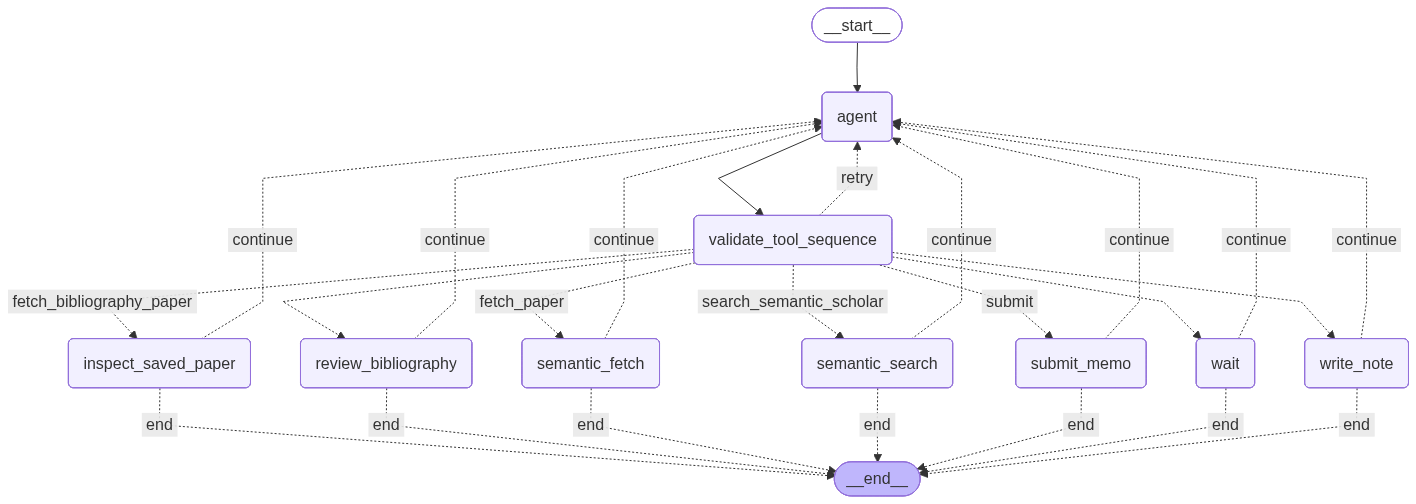

In [9]:
graph = build_graph(llm, tools, max_steps=MAX_STEPS)
print('LangGraph structure:')
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [7]:
MAX_STEPS

12

In [8]:
initial_state = {
    'messages': [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"{session.question}\n\n{session.instructions}"),
    ],
    'steps_executed': 0,
    'max_steps': MAX_STEPS,
    'submitted': False,
    'pending_tool_call': None,
    'phase': 'start_phase',
    'note_pending': False,
    'force_submit_mode': bool(MAX_STEPS),
    'force_submit_active': False,
    'force_submit_prompted': False,
}

print('Initial prompt stack:')
for idx, message in enumerate(initial_state['messages'], start=1):
    preview = message.content.strip()[:400]
    print(f"{idx}. {message.__class__.__name__}: {preview}")

final_state = graph.invoke(initial_state)
session.messages = messages_to_dict(final_state['messages'])

if session.final_memo is None:
    session.final_reward = -1.0
    session.reward_breakdown = {}
else:
    reward = compute_reward(
        question=session.question,
        memo=session.final_memo,
        bib=session.bib,
        step_count=session.step_count,
    )
    session.final_reward = float(reward.total)
    session.reward_breakdown = dict(reward.breakdown)

episode = {
    'run_id': str(uuid.uuid4()),
    'task_id': session.task_id,
    'question': session.question,
    'final_memo': session.final_memo or '',
    'reward': session.final_reward,
    'reward_breakdown': session.reward_breakdown,
    'bib': session.bib,
    'notes': session.notes,
    'steps': session.step_count,
    'tool_calls': session.tool_calls,
    'messages': session.messages,
}

append_jsonl(str(OUTPUT_PATH), episode)
print(f"Reward: {episode['reward']:.3f} | Steps: {episode['steps']} | Bib entries: {len(episode['bib'])}")
if episode['tool_calls']:
    last = episode['tool_calls'][-1]
    print('Last tool call:', last)
    if last.get('tool') != 'submit':
        print('WARNING: rollout did not end with submit; inspect the trace above.')
print('Episode appended to', OUTPUT_PATH)
episode['task_id'], episode['question']

Initial prompt stack:
1. SystemMessage: You are an expert policy analyst who is responding to a request-for-information issued by the government. 
For each task, you must thoroughly research the policy objective by thinking and planning out your steps, looking up academic papers, 
jotting down notes, and finishing with a policy memo that cites specific papers. 

Take multiple turns to think and search iteratively until you have sufficie
2. HumanMessage: How are US states leveraging carbon pricing mechanisms to fund climate resilience?

Use the tools to search Semantic Scholar, fetch papers, build a bibliography with reasons, take notes, then submit a final memo. You may issue at most 12 tool calls; reserve the final step for `submit`.
Reward: 3.850 | Steps: 13 | Bib entries: 0
Last tool call: {'step': 13, 'tool': 'submit', 'args': {'memo': 'Policy memo: How U.S. states are (and are not) leveraging carbon pricing to fund climate resilience\n\nExecutive summary\n- My targeted searches of

('policy_001',
 'How are US states leveraging carbon pricing mechanisms to fund climate resilience?')

In [12]:
import pandas as pd
rollout_data = pd.read_json('data/cache/rollouts_langgraph.jsonl', lines=True)

In [20]:
import pyperclip
pyperclip.copy(rollout_data['final_memo'].loc[lambda s: s != ''].iloc[0])

In [ ]:
print('Final memo:')
print('-' * 80)
print(episode['final_memo'])


In [ ]:
print('Bibliography (most recent run):')
for idx, entry in enumerate(episode['bib'], start=1):
    print(f"{idx}. {entry.get('title')} ({entry.get('year')}) - {entry.get('reason', '')}")


In [ ]:
print('Tool calls:')
for call in episode['tool_calls']:
    print(call)


In [ ]:
tasks_map = eval_load_tasks(TASKS_PATH)
rows = list(eval_load_jsonl(OUTPUT_PATH))
summaries = []
for row in rows:
    question = row.get('question') or tasks_map.get(row.get('task_id'), '')
    memo = row.get('final_memo') or row.get('memo') or ''
    step_count = int(row.get('steps') or row.get('step_count') or 0)
    bib = row.get('bib') or []
    reward = compute_reward(question=question, memo=memo, bib=bib, step_count=step_count)
    summaries.append({
        'task_id': row.get('task_id'),
        'reward': reward.total,
        'citation_reward': reward.breakdown['citation_reward'],
        'diversity_reward': reward.breakdown['diversity_reward'],
        'coverage_reward': reward.breakdown['coverage_reward'],
        'budget_penalty': reward.breakdown['budget_penalty'],
    })
if summaries:
    print_report(summaries)
else:
    print('No rollouts saved yet.')


# Test Semantic Scholar

In [10]:
from policy_src.policy_research_core.semanticscholar_api import SemanticScholarClient

TEST_QUERY = "US states carbon pricing funding climate resilience"
TEST_LIMIT = 20
TEST_MAX_PAGES = 5
TEST_YEAR = None  # e.g., '2020-'

s2_diag = SemanticScholarClient()
FIELDS = "paperId,title,year,venue,url,abstract,citationCount"


def probe_semantic_scholar(query: str, limit: int = 20, max_pages: int = 40, year: str | None = None):
    """Ping the Semantic Scholar Graph API page-by-page to surface bad offsets."""
    print(f"Testing Semantic Scholar search for '{query}' (limit={limit}, max_pages={max_pages}, year={year})")
    params = {"query": query, "fields": FIELDS, "limit": limit}
    if year:
        params["year"] = year
    offset = 0
    page = 0
    total = 0
    while True:
        if page >= max_pages:
            print(f"Reached max_pages={max_pages}; stopping (total rows fetched={total}).")
            break
        page_params = dict(params)
        if offset:
            page_params["offset"] = offset
        print(f" -> Requesting offset={page_params.get('offset', 0)}")
        try:
            payload = s2_diag._get("/paper/search", page_params)
        except Exception as exc:
            print(f" !! Request failed at offset {page_params.get('offset', 0)}: {exc}")
            raise
        data = payload.get("data", [])
        total += len(data)
        print(f"    Received {len(data)} rows (running total={total})")
        offset = payload.get("next")
        page += 1
        if not offset:
            print("    No further pages; reached end of results.")
            break
    return total

probe_semantic_scholar(TEST_QUERY, limit=TEST_LIMIT, max_pages=TEST_MAX_PAGES, year=TEST_YEAR)

Testing Semantic Scholar search for 'US states carbon pricing funding climate resilience' (limit=20, max_pages=5, year=None)
 -> Requesting offset=0
    Received 20 rows (running total=20)
 -> Requesting offset=20
    Received 20 rows (running total=40)
 -> Requesting offset=40
    Received 20 rows (running total=60)
 -> Requesting offset=60
    Received 20 rows (running total=80)
 -> Requesting offset=80
    Received 20 rows (running total=100)
Reached max_pages=5; stopping (total rows fetched=100).


100